# Introduction

In the class of machine learning approaches that are based on tree-like decision makers, many improved algorithms have been developed over the past two decades. We will go through three noteworthy designs that build on the idea of ensembles. The general idea is to train multiple models and combine them in various ways to improve performance.

There are two primary ways of doing this when it comes to decision trees. The first is to average the output of multiple trees which limits the variance of the output given the central limit theorem. The second way is to build trees in sequence and use the output of each one to reduce the bias in the next one.

# Bagging Regressor

A Bagging model works by dividing a dataset, training one tree per subset, and averaging the results. There are variants of the Bagging approach with distinct names determined by how the data is divided (i.e. Pasting, Bagging, Random Subspaces, Random Patches, etc...).

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_rcv1

In [112]:
# RCV1 is a moderately complex "real world" dataset
# it might take a minute to download the dataset

rcv1 = fetch_rcv1()
print(rcv1.DESCR)

.. _rcv1_dataset:

RCV1 dataset
------------

Reuters Corpus Volume I (RCV1) is an archive of over 800,000 manually 
categorized newswire stories made available by Reuters, Ltd. for research 
purposes. The dataset is extensively described in [1]_.

**Data Set Characteristics:**

    ==============     =====================
    Classes                              103
    Samples total                     804414
    Dimensionality                     47236
    Features           real, between 0 and 1
    ==============     =====================

:func:`sklearn.datasets.fetch_rcv1` will load the following 
version: RCV1-v2, vectors, full sets, topics multilabels::

    >>> from sklearn.datasets import fetch_rcv1
    >>> rcv1 = fetch_rcv1()

It returns a dictionary-like object, with the following attributes:

``data``:
The feature matrix is a scipy CSR sparse matrix, with 804414 samples and
47236 features. Non-zero values contains cosine-normalized, log TF-IDF vectors.
A nearly chronologi

In [185]:
# values are normalized so we don't have to worry about that
# convention has it that the training set should be very small compared to the test set 

x, xt, y, yt = train_test_split(rcv1.data, rcv1.target, test_size = 0.971)

x, xt, y, yt = x.toarray(), xt[0:20000].toarray(), y.toarray(), yt[0:20000].toarray()

In [167]:
# now that datasets are bigger, training takes longer
# this should take about 2 minutes on a modern CPU 

m = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

m.fit(x, y)

ŷ = m.predict(xt)
accuracy_score(yt, ŷ)

0.1369

In [188]:
# we are training the same tree but using bagging

mb = BaggingClassifier(DecisionTreeClassifier(max_depth=5, min_samples_leaf=5), 
                       n_estimators=10,
                       verbose=1)

mb.fit(x, y)

ValueError: y should be a 1d array, got an array of shape (23328, 103) instead.

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

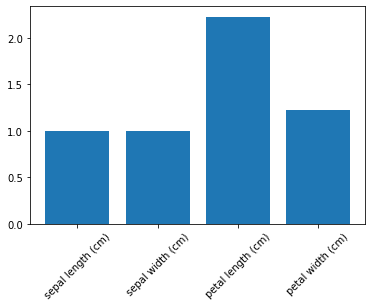

In [106]:
fi = np.mean([tree.feature_importances_ for tree in m.estimators_], axis=0)

# visualize the points
# log_e scale the importance
fig, ax = plt.subplots()
plt.bar(rcv1.feature_names, np.exp(fi))
plt.xticks(rotation=45)

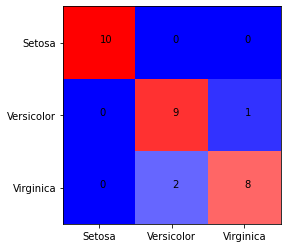

In [107]:
# we can visualize the accuracy of the model using a confusion matrix

acc = confusion_matrix(yt, ŷ)

plt.close('all')

fig, ax = plt.subplots()
ax.imshow(acc, cmap='bwr')
ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Setosa', 'Versicolor', 'Virginica'))
ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Setosa', 'Versicolor', 'Virginica'))
for i in range(3):
    for j in range(3):
        ax.text(j, i, acc[i][j], color='black')
plt.show()

# Random Forest
In random forests (see RandomForestClassifier and RandomForestRegressor classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.

Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features. (See the parameter tuning guidelines for more details).

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

In contrast to the original publication [B2001], the scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

The main parameters to adjust when using these methods is n_estimators and max_features. The former is the number of trees in the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees. The latter is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good default values are max_features=None (always considering all features instead of a random subset) for regression problems, and max_features="sqrt" (using a random subset of size sqrt(n_features)) for classification tasks (where n_features is the number of features in the data). Good results are often achieved when setting max_depth=None in combination with min_samples_split=2 (i.e., when fully developing the trees). Bear in mind though that these values are usually not optimal, and might result in models that consume a lot of RAM. The best parameter values should always be cross-validated. In addition, note that in random forests, bootstrap samples are used by default (bootstrap=True) while the default strategy for extra-trees is to use the whole dataset (bootstrap=False). When using bootstrap sampling the generalization accuracy can be estimated on the left out or out-of-bag samples. This can be enabled by setting oob_score=True.

Finally, this module also features the parallel construction of the trees and the parallel computation of the predictions through the n_jobs parameter. If n_jobs=k then computations are partitioned into k jobs, and run on k cores of the machine. If n_jobs=-1 then all cores available on the machine are used. Note that because of inter-process communication overhead, the speedup might not be linear (i.e., using k jobs will unfortunately not be k times as fast). Significant speedup can still be achieved though when building a large number of trees, or when building a single tree requires a fair amount of time (e.g., on large datasets).

# Gradient Tree Boosting